<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Carga y limpieza de los datos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>


# Índice

1. [Importar librerias](#1.-Importar-librerias)  
2. [Funciones auxiliares](#2.-Funciones-auxiliares)  
3. [Carga del Dataset](#3.-Carga-del-Dataset)  
4. [Limpieza de los datos](#4.-Limpieza-de-los-datos)  
   * 4.1 [Estudio de las columnas](##4.1-Estudio-de-las-columnas)
   * 4.2 [Tratamiento de los duplicados y de los nulos](##4.2-Tratamiento-de-los-duplicados-y-de-los-nulos)
   * 4.3 [Tratamiento de las variables categóricas](##4.3-Tratamiento-de-las-variables-categoricas)
      * 4.3.1 [Tratamiento de las variables categóricas binarias](###4.3.1-Tratamiento-de-las-variables-categoricas-binarias)
      * 4.3.2 [Tratamiento de las variables categóricas no binarias](###4.3.2-Tratamiento-de-las-variables-categoricas-no-binarias)
5. [Correlacion](#5.-Correlacion)  
6. [Codificacion One-Hot](#6.-Codificacion-One-Hot)  
7. [Create Test](#7.-Create-Test)  
8. [Exportar CSV](#8.-Exportar-CSV)
9. [Referencias](#9.-Referencias)


# 1. Importar librerias

In [166]:
import pandas as pd
import numpy as np

from datetime import datetime
import json


import matplotlib.pyplot as plt
import seaborn as sns


import spacy
from spacy import displacy


# 2. Funciones auxiliares

In [167]:
def extract_month(date, mode=0):
    if pd.isna(date):
        return mode
    return datetime.strptime(date, '%d-%b-%y').month

In [168]:
def month_to_quarter(month):
    if month == 0:
        return 0
    return np.ceil(month / 3).astype(int)

In [169]:
def print_counts(dataframe_function):
    
    value_counts = dataframe_function.value_counts()
    sorted_values = sorted(value_counts.index)
    print("value_counts", ", ".join(sorted_values))
    print("\nNúmero de apariciones:\n", value_counts)


# 3. Carga del Dataset

In [170]:
url = "data/train.csv" 
data = pd.read_csv(url)
df = data.copy()

url2 = "data/test_nolabel.csv"
df_test = pd.read_csv(url2)

Configuramos Pandas para mostrar todas las columnas de un DataFrame al imprimirlo, y luego mostramos las primeras filas del DataFrame df.

In [171]:
pd.set_option('display.max_columns', None)
df.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


Con *Info* desplegamos la información del dataframe para saber con que datos trabajaremos en cada una de las columnas

In [172]:
df.info

<bound method DataFrame.info of                id  label                                          statement  \
0     81f884c64a7      1  China is in the South China Sea and (building)...   
1     30c2723a188      0  With the resources it takes to execute just ov...   
2     6936b216e5d      0  The (Wisconsin) governor has proposed tax give...   
3     b5cd9195738      1  Says her representation of an ex-boyfriend who...   
4     84f8dac7737      0  At protests in Wisconsin against proposed coll...   
...           ...    ...                                                ...   
8945  44edff2b865      1  If Rhode Island does a hybrid [retirement] pla...   
8946  4a63b5f9c16      1  The new health care law will force seniors int...   
8947  7c57fa8e81c      0  The health insurance plan that (members of Con...   
8948  2375e3cf4b7      1  No one in American history has moved from a Ju...   
8949  5ae9b14e6e5      0  Says the Army is spending $7 million to sponso...   

                   

Gracias a *shape* podemos saber las dimensiones del dataframe, de esta maenra podemos saber la cantidad de filas que tenemos en un incio y la cantidad de columnas con las que trabajaremos

In [173]:
df.shape

(8950, 8)

Visualización del nombre de todas las columnas para plantear la limpieza

In [174]:
df.columns

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation'],
      dtype='object')


Visualización del estadisticos de las columnas numericas para plantear la limpieza

# 4. Limpieza de los datos

## 4.1 Estudio de las columnas

This dataset is related to false political claim detection, containing labeled statements (or claims) along with metadata about the speaker, subject, and other contextual information. Below is a detailed breakdown of the dataset's structure and key characteristics:

| **Field Name**      | **Data Type** | **Description**                                                                 |
|----------------------|---------------|---------------------------------------------------------------------------------|
| **id**              | Text          | Unique identifier                                                              |
| **label**           | Integer       | Truthfulness score. Binary classification: 1 = true, 0 = false                |
| **statement**       | Text          | Text of the claim                                                              |
| **subject**         | Text          | Topic of the claim                                                             |
| **speaker**         | Text          | Person making the claim                                                        |
| **speaker_job**     | Text          | Occupation of the speaker                                                      |
| **state_info**      | Text          | Geographic context                                                             |
| **party_affiliation** | Text        | Political party of the speaker                                                 |


Visualización de los tipos de cada columna

In [175]:
df.dtypes

id                   object
label                 int64
statement            object
subject              object
speaker              object
speaker_job          object
state_info           object
party_affiliation    object
dtype: object

Visualizacón de valores distintos que tienen cada columna

In [176]:
# Obtener el número de valores distintos de cada columna
valores_distintos = {columna: df[columna].nunique() for columna in df.columns}

# Mostrar el número de valores distintos de cada columna
for columna, num_valores in valores_distintos.items():
    print(f"Columna: {columna}, Valores distintos: {num_valores}")

Columna: id, Valores distintos: 8950
Columna: label, Valores distintos: 2
Columna: statement, Valores distintos: 8939
Columna: subject, Valores distintos: 3409
Columna: speaker, Valores distintos: 2634
Columna: speaker_job, Valores distintos: 1090
Columna: state_info, Valores distintos: 78
Columna: party_affiliation, Valores distintos: 24


Eliminar id al ser información no necesaria

In [177]:
dfc = df.drop(columns='id')
dfc.head()

,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


- Obeservar si el dataset está balanceado

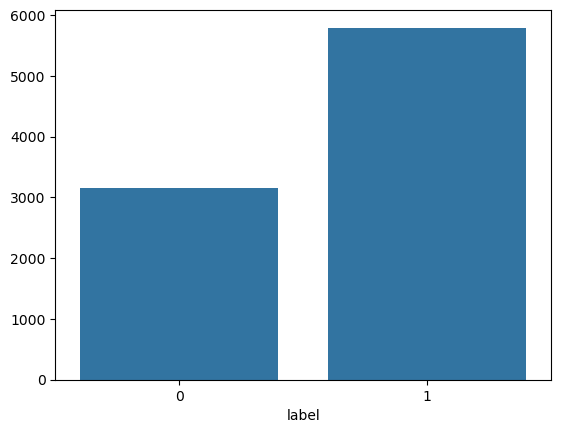

In [178]:
x = dfc['label'].value_counts()
sns.barplot(x=x.index, y=x.values)
plt.show()

Está bastante desequilibrado; hay muchos más textos que no son vulos que son vulos.

## 4.2 Tratamiento de los duplicados y de los nulos

Comprobación de duplicados

In [179]:
print(dfc.duplicated().any())

False


No hay duplicados

Comporbación de si existen nulos y en que columnas se encuentran

In [180]:
dfc.isnull().sum() 

label                   0
statement               0
subject                 0
speaker                 0
speaker_job          2482
state_info           1930
party_affiliation       0
dtype: int64

Al ser demasiados nulos intentaremos sacar la información de otras columnas

## 4.3 Tratamiento features

### 4.3.1 Features

- Statement

In [181]:
# Obtener el conteo de valores únicos de 'speaker'
statement_counts = dfc['statement'].value_counts()

# Convertir a diccionario
statement_counts_dict = statement_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study-statement/statements.json', 'w', encoding='utf-8') as f:
    json.dump(statement_counts_dict, f, ensure_ascii=False, indent=2)

Poner todas las letras en minúscula

In [182]:
dfc['statement'] = dfc['statement'].str.lower()

In [183]:
from collections import defaultdict
nlp = spacy.load('en_core_web_lg')
en_stopwords = nlp.Defaults.stop_words

#Collection
def create_collection(label):
    collection=[]
    
    for x in dfc[dfc['label']==label]['statement'].str.split():
        for i in x:
            collection.append(i)
    return collection

Common stopwords in no fake claims, label 0

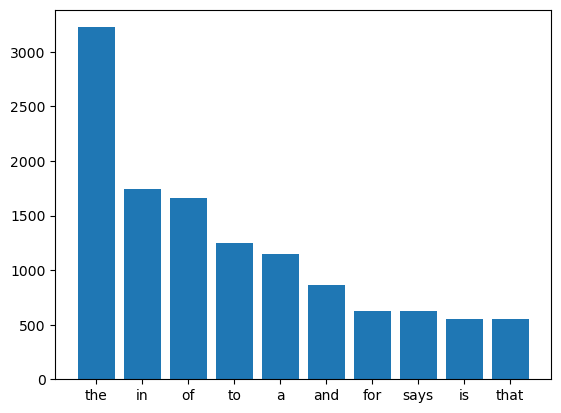

In [184]:

#Common stopwords in no fake claims, label 0
collection=create_collection(0)

dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

#Common stopwords in fake claims, label 1

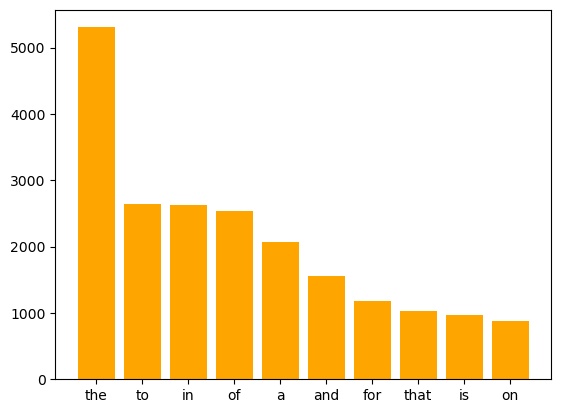

In [185]:
collection=create_collection(1)

dic=defaultdict(int)
for word in collection:
    if word in en_stopwords:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y,color='orange')
plt.show()

Como podemos comprobar que en tanto en fake claims como en no fake claims comparten palabras muy similares

Ahora analizaremos la puntuación

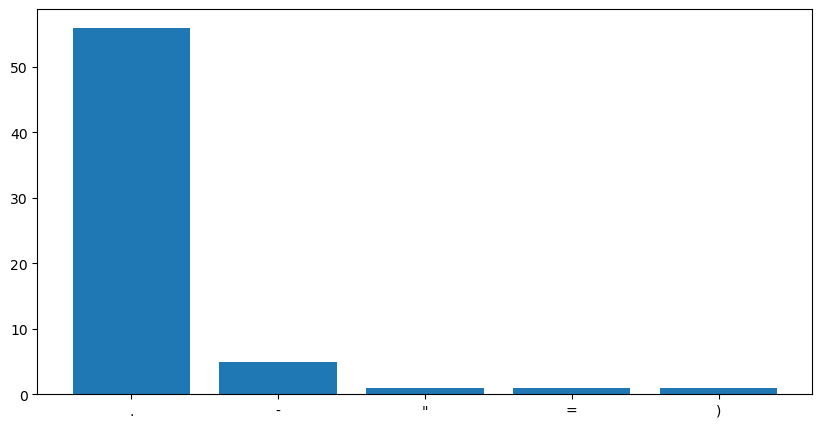

In [186]:
import string
#Common punctuation in offensive texts
plt.figure(figsize=(10,5))
corpus=create_collection(0)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)
plt.show()

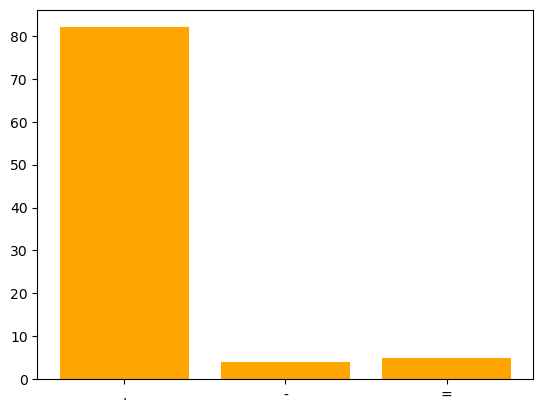

In [187]:
import string

corpus=create_collection(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='orange')
plt.show()

Como podemos comprobar no hay una gran diferencia entre ambos tipos de *claims*

In [ ]:
import re
import string

# Contadores globales
url_changes = 0
punct_changes = 0
stopword_changes = 0

# Function to remove URLs
def remove_URL(text):
    global url_changes
    url = re.compile(r'\b\w+\.com\b', re.IGNORECASE)  # Detectar URLs terminadas en .com
    new_text = url.sub(r'', text)
    # url_changes += 1
    if new_text != text:
        url_changes += 1
    return new_text

# Function to remove punctuation
def remove_punct(text):
    global punct_changes
    table = str.maketrans('', '', string.punctuation)
    new_text = text.translate(table)
    if new_text != text:
        punct_changes += 1
    return new_text

# Function to remove stopwords from the text
def remove_stop_words(text):
    global stopword_changes
    cleanText = ''
    phrase = nlp(text)
    for token in phrase:
        if not token.is_stop:
            cleanText += ' ' + token.text
    if cleanText.strip() != text.strip():
        stopword_changes += 1
    return cleanText

# Aplicar las funciones
dfc['statement'] = dfc['statement'].apply(lambda x: remove_URL(x))
dfc['statement'] = dfc['statement'].apply(lambda x: remove_punct(x))
dfc['statement'] = dfc['statement'].apply(remove_stop_words)

# Mostrar los contadores
print(f"URLs eliminadas: {url_changes}")
print(f"Puntuaciones eliminadas: {punct_changes}")
print(f"Stopwords eliminadas: {stopword_changes}")

URLs eliminadas: 2
Puntuaciones eliminadas: 8828
Stopwords eliminadas: 8914


In [189]:
dfc

,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,1,china south china sea buildinga military fort...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,0,resources takes execute months iraq war fully...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,0,wisconsin governor proposed tax giveaways cor...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,1,says representation exboyfriend friend family...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,0,protests wisconsin proposed collective bargai...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican
...,...,...,...,...,...,...,...
8945,1,rhode island hybrid retirement plan state nation,"pensions,public-service,retirement,workers",lincoln-chafee,NaN,Rhode Island,democrat
8946,1,new health care law force seniors barack obam...,"medicare,message-machine,retirement",dan-coats,NaN,Indiana,republican
8947,0,health insurance plan members congress differ...,health-care,steve-southerland,"U.S. Representative, Florida District 2",Florida,republican
8948,1,american history moved june 16 announcement 2...,"elections,history",newt-gingrich,"Co-host on CNN's ""Crossfire""",Georgia,republican


In [191]:
# Obtener el conteo de valores únicos de 'speaker'
statement_counts = dfc['statement'].value_counts()

# Convertir a diccionario
statement_counts_dict = statement_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study-statement/statements_v1.json', 'w', encoding='utf-8') as f:
    json.dump(statement_counts_dict, f, ensure_ascii=False, indent=2)

Ahora analizamos la frecuencia de las palabras en funcion del tipo de *claim*

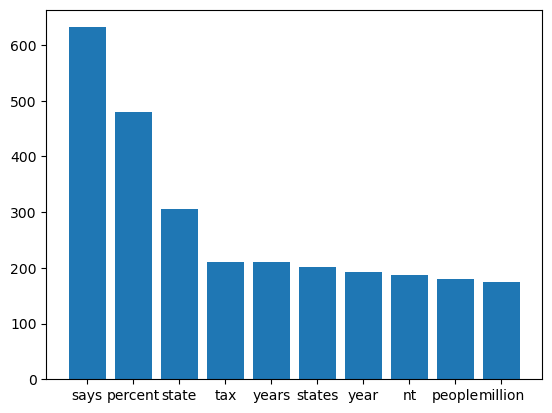

In [165]:
#Common words in no fake claims
collection=create_collection(0)

dic=defaultdict(int)

for word in collection:
    dic[word]+=1  
    
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

In [ ]:
#Common words in fake claims
collection=create_collection(1)

dic=defaultdict(int)

for word in collection:
    dic[word]+=1  
    
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y,color='orange')
plt.show()


#### 1. Limipieza y Normalización del Texto 

#### 1.1 Eliminar Ruido
Quitar URLs, etiquetas HTML, menciones, hashtags y caracteres no alfanúmericos

In [271]:
# Obtener el conteo de valores únicos de 'speaker'
statement_counts = dfc['statement'].value_counts()

# Convertir a diccionario
statement_counts_dict = statement_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/statements.json', 'w', encoding='utf-8') as f:
    json.dump(statement_counts_dict, f, ensure_ascii=False, indent=2)

#### 1.2 Convertir a minúsculas

### 4.3.2 Resto de features


- subject

In [253]:
# dfc['subject'].value_counts()

dfc['subject'].iloc[1:10]                    

1                                          health-care
2             corporations,pundits,taxes,abc-news-week
3    candidates-biography,children,ethics,families,...
4                       health-care,labor,state-budget
5                                 candidates-biography
6                     legal-issues,state-budget,states
7                                                 iraq
8                                          immigration
9     economy,income,retirement,social-security,wealth
Name: subject, dtype: object

In [254]:
dfc['subject_list'] = (
    dfc['subject']
    .str.split(',')
    .apply(lambda lst: [s.strip() for s in lst if s.strip()])
)

# 3. “Explode” para tener una fila por cada etiqueta y contar
subjects_exploded = dfc.explode('subject_list')
subject_counts = subjects_exploded['subject_list'].value_counts()
print(subject_counts)
# 4. Convertir a diccionario
# subject_count_dict = subject_counts.to_dict()
# with open('json-study/subject_counts.json', 'w', encoding='utf-8') as f:
#     json.dump(subject_count_dict, f, ensure_ascii=False, indent=2)


subject_list
economy           997
health-care       991
taxes             857
federal-budget    646
education         638
                 ... 
after-the-fact      1
nightlife           1
food                1
homeless            1
death-penalty       1
Name: count, Length: 142, dtype: int64


Vamos a cortar el diccionario por el 1% de los datos para evitar posible overfiting

In [255]:
percentage = 0.01
num_filas = dfc.shape[0]
cut_count_namber = int(num_filas * percentage)
print("Número de filas para el corte:", cut_count_namber)

Número de filas para el corte: 89


In [256]:
from sklearn.preprocessing import MultiLabelBinarizer
df2 = dfc.copy()

frequent_subjects = set(subject_counts[subject_counts >= cut_count_namber].index)

# Sustituir las etiquetas raras por 'other_subject'
df2['subject_list_clean'] = df2['subject_list'].apply(
    lambda lst: [s if s in frequent_subjects else 'other_topics' for s in lst]
)

# Binariza con MultiLabelBinarizer
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(df2['subject_list_clean'])

# DataFrame de one-hot y concatenación
df_subjects_onehot = pd.DataFrame(
    onehot,
    columns=mlb.classes_,
    index=df2.index
)

df2 = pd.concat([df2, df_subjects_onehot], axis=1)

# df2.head()
df2.shape

(8950, 71)

- Speaker

In [257]:
# Obtener el conteo de valores únicos de 'speaker'
speaker_counts = dfc['speaker'].value_counts()

# Convertir a diccionario
speaker_counts_dict = speaker_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/speaker_counts.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_counts_dict, f, ensure_ascii=False, indent=2)

- speaker_job

In [258]:
# Obtener el conteo de valores únicos de 'speaker'
speaker_job_counts = dfc['speaker_job'].value_counts()

# Convertir a diccionario
speaker_job_counts_dict = speaker_job_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/speaker_job_counts.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_job_counts_dict, f, ensure_ascii=False, indent=2)

- state_info

In [259]:
# Obtener el conteo de valores únicos de 'speaker'
state_info_counts = dfc['state_info'].value_counts()

# Convertir a diccionario
state_info_counts_dict = state_info_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/state_info_counts.json', 'w', encoding='utf-8') as f:
    json.dump(state_info_counts_dict, f, ensure_ascii=False, indent=2)

- party_affiliation

In [260]:
# dfc['party_affiliation'].value_counts()       

# Obtener el conteo de valores únicos de 'speaker'
party_affiliation_counts = dfc['party_affiliation'].value_counts()

# Convertir a diccionario
party_affiliation_counts_dict = party_affiliation_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/party_affiliation_counts.json', 'w', encoding='utf-8') as f:
    json.dump(party_affiliation_counts_dict, f, ensure_ascii=False, indent=2)


In [261]:
mapping = {
    # Major parties
    'republican': 'Republican',
    'democrat': 'Democrat',
    'democratic-farmer-labor': 'Democrat',

    # Independents / None
    'none': 'Independent_None',
    'independent': 'Independent_None',
    'newsmaker': 'Independent_None',
    'journalist': 'Independent_None',
    'columnist': 'Independent_None',
    'activist': 'Independent_None',
    'talk-show-host': 'Independent_None',

    # Third parties
    'libertarian': 'Third_Party',
    'green': 'Third_Party',
    'constitution-party': 'Third_Party',
    'liberal-party-canada': 'Third_Party',

    # Organizations
    'organization': 'Organization',
    
    # Officials  
    'state-official': 'Official',
    'business-leader': 'Official',
    'labor-leader': 'Official',
    'education-official': 'Official',
    'government-body': 'Official',

    # Tea Party
    'tea-party-member': 'Tea_Party',
    'ocean-state-tea-party-action': 'Tea_Party',
}

def group_party(x):
    return mapping.get(x, 'Other')  # anything else → 'Other'

df['party_group'] = df['party_affiliation'].apply(group_party)

# Recuento de las nuevas categorías
print(df['party_group'].value_counts())


party_group
Republican          3947
Democrat            2899
Independent_None    1824
Organization         197
Third_Party           40
Official              32
Tea_Party              9
Other                  2
Name: count, dtype: int64


# 7. Create Test

In [262]:
dfa = df_test.copy() # Backup del dataframe original
dfa.dtypes.sort_index()

id                   object
party_affiliation    object
speaker              object
speaker_job          object
state_info           object
statement            object
subject              object
dtype: object

In [263]:
# Opcional: Eliminar filas con valores nulos en el DataFrame 'df_test'
# df_test = df_test.dropna()

# # Mostrar la cantidad de valores nulos restantes en 'df_test'
print(df_test.isnull().sum())

id                      0
statement               0
subject                 0
speaker                 0
speaker_job          1082
state_info            818
party_affiliation       0
dtype: int64


- Speaker

In [264]:
# Obtener el conteo de valores únicos de 'speaker'
speaker_counts = dfa['speaker'].value_counts()

# Convertir a diccionario
speaker_counts_dict = speaker_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/speaker_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_counts_dict, f, ensure_ascii=False, indent=2)

- speaker_job

In [265]:
# Obtener el conteo de valores únicos de 'speaker'
speaker_job_counts = dfa['speaker_job'].value_counts()

# Convertir a diccionario
speaker_job_counts_dict = speaker_job_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/speaker_job_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_job_counts_dict, f, ensure_ascii=False, indent=2)

- state_info

In [266]:
# Obtener el conteo de valores únicos de 'speaker'
state_info_counts = dfa['state_info'].value_counts()

# Convertir a diccionario
state_info_counts_dict = state_info_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/state_info_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(state_info_counts_dict, f, ensure_ascii=False, indent=2)

- party_affiliation

In [267]:
# dfc['party_affiliation'].value_counts()       

# Obtener el conteo de valores únicos de 'speaker'
party_affiliation_counts = dfa['party_affiliation'].value_counts()

# Convertir a diccionario
party_affiliation_counts_dict = party_affiliation_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study/party_affiliation_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(party_affiliation_counts_dict, f, ensure_ascii=False, indent=2)


# 8. Exportar CSV

Comparar los dos dataset para ver que todo esta bien

In [268]:
df_check =  pd.read_csv("data/test_nolabel.csv")

In [269]:
# Comparar las columnas de dfc y df_testn
columns_dfc = set(dfc.columns)
columns_df_testn = set(df_testn.columns)

# Encontrar las diferencias
differences = columns_dfc.symmetric_difference(columns_df_testn)

# Verificar si la única diferencia es 'id'
if differences == {'id', 'Accept'}:
    print("La única diferencia entre las columnas es 'id' y 'Accept'.")
else:
    print("Existen otras diferencias en las columnas:", differences)

NameError: name 'df_testn' is not defined

Guardar en *formated* los csv train y test

In [ ]:
# Exportar el DataFrame 'dfn' a un archivo CSV
dfc.to_csv('./formated/train_exportado_v2.csv', index=False)

df_testn.to_csv('./formated/test_exportado_v2.csv', index=False)

Todas las features:

In [ ]:
all_features = [
    # Características numéricas
    'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',

    # Características categóricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',

    # Características categóricas codificadas
    'ApprovalFY_Grouped_cod', 'NoEmp_Grouped_cod', 
    'DisbursementGross_Grouped_cod',

    # Características temporales
    'ApprovalDate', 'DisbursementDate', 
    'ApprovalDate_quarter', 'DisbursementDate_quarter',

    # Características categóricas sin codificar
    'Bank_Categorized_cod', 'BankState_Categorized_cod',
    'ApprovalFY_Grouped', 'NoEmp_Grouped', 
    'DisbursementGross_Grouped',

    # Características relacionadas con Bank tras un One Hot Encoding
    'Bank_CAPITAL ONE NATL ASSOC', 'Bank_CITIZENS BANK NATL ASSOC',
    'Bank_COMMUNITY CAP. DEVEL CORP', 'Bank_FIFTH THIRD BANK',
    'Bank_FIRSTMERIT BANK, N.A.', 'Bank_HAMILTON CNTY DEVEL COMPANY IN',
    'Bank_JPMORGAN CHASE BANK NATL ASSOC',
    'Bank_KEYBANK NATIONAL ASSOCIATION', 'Bank_Otros',
    'Bank_PNC BANK, NATIONAL ASSOCIATION',
    'Bank_THE HUNTINGTON NATIONAL BANK',
    'Bank_U.S. BANK NATIONAL ASSOCIATION',
    'Bank_WELLS FARGO BANK NATL ASSOC',

    # Características relacionadas con BankState tras un One Hot Encoding
    'BankState_CA', 'BankState_DE', 'BankState_IL', 'BankState_IN',
    'BankState_OH', 'BankState_Otros', 'BankState_RI', 
    'BankState_SD', 'BankState_VA',
]


# 9. Referencias

* [Alexisbcook. (2023, 21 abril). Categorical variables. Kaggle.](https://www.kaggle.com/code/alexisbcook/categorical-variables)
* [pandas documentation — pandas 2.2.3 documentation. (s. f.).](https://pandas.pydata.org/docs/)